# Change the MODEL_NAME with any of this VLLM:
1. gpt-4o/nova-pro
2. pixtral-large-latest
3. qwen-plus

4. gemini-2.5-flash-preview
5. gemini-2.5-pro-preview

Image-Emotion
[  ] finish VLM analysis
[  ] add R1-Omni if possible
[  ] basic analysis (1-2 days)
[  ] paperwriting

Voice-Emotion
[  ] annotation data
[  ] NeurIPS target is probably too soon


In [ ]:
import os
import json
import requests
import base64

# Replace 'your_api_key_here' with your actual API key as a string
API_KEY = ""  # Ensure your API key is provided as a string

MODEL_NAME = "claude-3-7-sonnet-latest"
FOLDER_NAME = "stance-detection-part-1"

failed_list = []

# Define the input and output paths
input_folder = '' #img_failed_1' #images-stance-detection-part-4'       # Folder where your images are stored
output_folder = ''     # Base output folder for annotations

# Define separate output folders for with and without "aha" prompt
output_folder_without_aha = os.path.join(output_folder, 'without_aha_moment')
output_folder_with_aha = os.path.join(output_folder, 'with_aha_moment')

# Ensure the output folders exist
os.makedirs(output_folder_without_aha, exist_ok=True)
os.makedirs(output_folder_with_aha, exist_ok=True)

# API endpoint and headers (adjust according to HyperLab's API documentation)
API_ENDPOINT = 'https://api.hyprlab.io/v1/chat/completions'  # HyperLab API endpoint

headers = {
    'Authorization': f'Bearer {API_KEY}',
    # 'Content-Type' is omitted to let 'requests' library set it appropriately
}

# The prompt template
PROMPT_TEXT = '''
Please do the annotation of the image according to the instructions. The 0 shouldn't be in the result (the best way is to omit keys with emotions that are not present in the image). These are the instructions: {{ "instructions": "{instructions}", "options": {options} }}. Use this example output format:

Example:
{example_output}

Please provide the full output in this exact format as a JSON object without any code block formatting or additional text. Do not include any explanations or commentary—just the JSON object.

Remember to include all of the keys and values from the example, updating "file_name" with the actual image file name "{file_name}". Give the output now.
'''

# The additional message to be included if the 'value' length is not 25 or contains zeros
ADDITIONAL_PROMPT = '''
Wait, wait. Wait. That’s an aha moment. I can flag you here because you are not following my instructions.
Please ensure that the "value" dictionary in your output:

1. Contains exactly 25 key-value pairs, as per the example.
2. Does not include any keys with a value of 0 (omit keys for emotions that are not present).

Provide the corrected JSON output now.
'''

# Full instructions provided in your prompt
INSTRUCTIONS = """<div class='max-w-4xl mx-auto bg-white p-6 rounded-lg shadow'><p class='mb-4'>This project is about assessing the emotions that a person, shown in an image, appears to be feeling, according to <b><i>your opinion</i></b>. All faces that you find in this project are generated by AI and do not resemble any real existing person. This study aims to improve the abilities of AI assistants to empathetically react to their user's feelings in contexts like counseling, therapy, and social support.</p><p class='mb-4'>To help these systems to make a realistic assessment of their users' feelings, it is important that you fulfill these tasks with your honest <b><i>uncensored</i></b> and <b><i>spontaneous intuitions</i></b>.</p><p class='mb-4'>Do not hesitate to omit certain categories you consider irrelevant for a given image or rate other categories highly if you feel this is appropriate.</p><p class='mb-4'>Emotion recognition is always influenced by cultural and social factors and is therefore never 100% objective. Therefore, <b><i>don't worry too much about whether your evaluation is right or wrong</i></b>, but listen to your intuition and first impressions. After choosing the categories, you will adjust the slider from 0 (emotions not present) over 1 (emotions are weakly present) to 7 (the emotions are very strong). If you are unsure, take another look at the face and ask yourself how much this person seems to be feeling for the given emotions right now, and then adjust the slider to the number that comes to your mind.</p><p class='my-4 italic'>Whatever comes to your mind: <b><i>It is okay</i></b>.</p><div class='w-full'><div class='w-full'><b>Recommendations</b></div><div class='flex'><div class='flex flex-col justify-start items-end px-2'>1)</div><div>Close your eyes for a moment when you start annotating a new sample and focus for ~10 seconds on your breath, until you feel calm & relaxed. Feeling relaxed will make you more perceptive of small nuances in the face and make it easier for you to listen to your intuition.</div></div><div class='flex'><div class='flex flex-col justify-start items-end px-2'>2)</div><div>Then look at the face & ask yourself for each category: <b><i>How much does the category seem to describe what this person seems to be feeling</i></b>?</div></div><div class='flex'><div class='flex flex-col justify-start items-end px-2'>3)</div><div>Repeat the process for the emotions: <b><i>How much do the given emotions seem to describe what this person seems to be feeling</i></b>? Instead of if a category is present or not (clicked or not), you now adjust the slider accordingly (leave it as it is for not present, or slide it to a value between 1 to 7 if present). Trust your gut feeling, your subjective intuition. It is fine.</div></div><div class='flex'><div class='flex flex-col justify-start items-end px-2'>4)</div><div>After you have processed all emotions, move on to the next sample starting with step 1) by clicking <i class='bg-green-200 px-1 rounded-sm'>Submit and Proceed</i>.</div></div></div><p class='my-4'>Do the annotations in a calm environment in a relaxed state of mind. A tea or coffee (with or without cookies) and listening to relaxing music might help.</p><p class='italic mb-4'>Listen to your heart, <b><i>trust your intuition & try to have fun</i></b>. 😊</p></div>"""

# All labels and buttons included in OPTIONS
OPTIONS = {
    "labels": {
        "Amusement": [
            "lighthearted fun", "amusement", "mirth", "joviality", "laughter",
            "playfulness", "silliness", "jesting", "delight"
        ],
        "Elation": [
            "happiness", "excitement", "joy", "exhilaration", "laughter",
            "jubilation", "cheerfulness"
        ],
        "Pleasure/Ecstasy": [
            "ecstasy", "pleasure", "bliss", "beatitude"
        ],
        "Contentment": [
            "contentment", "relaxation", "peacefulness", "calmness",
            "satisfaction", "ease", "serenity", "fulfillment",
            "gladness", "lightness", "tranquility"
        ],
        "Thankfulness/Gratitude": [
            "thankfulness", "gratitude", "appreciation", "gratefulness"
        ],
        "Affection": [
            "sympathy", "compassion", "warmth", "trust", "caring",
            "forgiveness", "devotion", "tenderness", "reverence"
        ],
        "Infatuation": [
            "infatuation", "having a crush", "romantic desire", "fondness",
            "butterflies in the stomach", "adoration"
        ],
        "Hope/Enthusiasm/Optimism": [
            "hope", "enthusiasm", "optimism", "anticipation", "courage",
            "encouragement", "zeal", "fervor", "inspiration", "determination"
        ],
        "Triumph": [
            "triumph", "superiority", "hubris"
        ],
        "Pride": [
            "pride", "dignity", "self-confidence", "honor", "self-consciousness"
        ],
        "Interest": [
            "interest", "fascination", "curiosity", "need for cognition"
        ],
        "Awe": [
            "awe", "awestruck", "wonder"
        ],
        "Astonishment/Surprise": [
            "astonishment", "surprise", "amazement", "shock", "startlement"
        ],
        "Concentration": [
            "concentration", "deep focus", "engrossment", "absorption", "attention"
        ],
        "Contemplation": [
            "contemplation", "thoughtfulness", "pondering", "reflection",
            "meditation", "brooding", "pensiveness"
        ],
        "Relief": [
            "relief", "respite", "alleviation", "solace", "comfort", "liberation"
        ],
        "Longing": [
            "yearning", "longing", "pining", "wistfulness", "nostalgia",
            "craving", "desire", "benign envy", "homesickness"
        ],
        "Teasing": [
            "teasing", "bantering", "mocking playfully", "ribbing", "provoking lightly"
        ],
        "Impatience and Irritability": [
            "impatience", "irritability", "irritation", "restlessness",
            "short-temperedness", "exasperation"
        ],
        "Sexual Lust": [
            "sexual lust", "carnal desire", "lust", "feeling horny", "feeling turned on"
        ],
        "Doubt": [
            "doubt", "distrust", "suspicion", "skepticism", "uncertainty", "pessimism"
        ],
        "Fear": [
            "fear", "terror", "dread", "apprehension", "alarm", "horror",
            "panic", "nervousness"
        ],
        "Distress": [
            "worry", "anxiety", "unease", "anguish", "trepidation", "concern",
            "upset", "pessimism", "foreboding"
        ],
        "Confusion": [
            "confusion", "bewilderment", "disorientation", "perplexity"
        ],
        "Embarrassment": [
            "embarrassment", "shyness", "mortification", "discomfiture",
            "awkwardness", "self-consciousness"
        ],
        "Shame": [
            "shame", "guilt", "remorse", "humiliation", "contrition"
        ],
        "Disappointment": [
            "disappointment", "regret", "dismay", "letdown", "chagrin"
        ],
        "Sadness": [
            "sadness", "sorrow", "grief", "melancholy", "dejection",
            "despair", "self-pity", "sullenness", "heartache",
            "mournfulness", "misery"
        ],
        "Bitterness": [
            "resentment", "acrimony", "bitterness", "cynicism",
            "rancor", "malicious envy"
        ],
        "Contempt": [
            "contempt", "disapproval", "scorn", "disdain", "loathing",
            "detestation"
        ],
        "Disgust": [
            "disgust", "revulsion", "repulsion", "abhorrence", "loathing"
        ],
        "Anger": [
            "anger", "rage", "fury", "hate", "irascibility",
            "enragement", "wrath", "annoyance"
        ],
        "Malevolence/Malice": [
            "spite", "sadism", "malevolence", "malice", "malicious envy",
            "revenge", "desire to harm", "schadenfreude"
        ],
        "Sourness": [
            "sourness", "tartness", "acidity", "acerbity", "sharpness"
        ],
        "Pain": [
            "physical pain", "suffering", "torment", "ache", "agony"
        ],
        "Helplessness": [
            "helplessness", "hopelessness", "powerlessness",
            "desperation", "submission"
        ],
        "Fatigue/Exhaustion": [
            "fatigue", "exhaustion", "weariness", "lethargy",
            "burnout"
        ],
        "Emotional Numbness": [
            "numbness", "detachment", "insensitivity", "emotional blunting",
            "apathy", "existential void", "boredom", "stoicism", "indifference"
        ],
        "Intoxication/Altered States of Consciousness": [
            "being drunk", "stupor", "intoxication", "disorientation",
            "altered perception"
        ],
        "Jealousy & Envy": [
            "jealousy", "envy", "covetousness"
        ]
    },
    "buttons": {
        "Positive High-Energy Emotions": [
            "Amusement", "Elation", "Pleasure/Ecstasy", "Hope/Enthusiasm/Optimism",
            "Triumph", "Interest", "Awe", "Astonishment/Surprise", "Teasing"
        ],
        "Positive Low-Energy Emotions": [
            "Contentment", "Thankfulness/Gratitude", "Affection", "Relief",
            "Contemplation", "Pride"
        ],
        "Negative High-Energy Emotions": [
            "Fear", "Anger", "Malevolence/Malice", "Disgust",
            "Impatience and Irritability", "Distress"
        ],
        "Negative Low-Energy Emotions": [
            "Sadness", "Bitterness", "Contempt", "Disappointment",
            "Shame", "Emotional Numbness", "Doubt", "Jealousy & Envy",
            "Embarrassment", "Helplessness"
        ],
        "Cognitive States and Processes": [
            "Concentration", "Confusion"
        ],
        "Physical and Exhaustive States": [
            "Pain", "Fatigue/Exhaustion",
            "Intoxication/Altered States of Consciousness", "Sourness"
        ],
        "Longing & Lust": [
            "Longing", "Sexual Lust", "Infatuation"
        ]
    }
}

# Example output with exactly 25 key-value pairs and no zeros
EXAMPLE_OUTPUT = '''
{
  "key": ["stance-detection-part-1", "claude-3-7-sonnet-latest", "mj_data_108_U2.png"],
  "value": {
    "<CATEGORY>|<EMOTION>": <Int<1-7>, if 0 key-value pair should be ommitted>,
    "Positive High-Energy Emotions|Triumph": score,
    "Positive High-Energy Emotions|Interest": score,
    "Positive High-Energy Emotions|Awe": score,
    "Positive High-Energy Emotions|Astonishment/Surprise": score,
    "Positive Low-Energy Emotions|Contemplation": score,
    "Positive Low-Energy Emotions|Pride": score,
    "Negative High-Energy Emotions|Anger": score,
    "Negative High-Energy Emotions|Fear": score,
    "Positive Low-Energy Emotions|Contentment": score,
    "Negative High-Energy Emotions|Malevolence/Malice": score,
    "Negative High-Energy Emotions|Disgust": score,
    "Negative High-Energy Emotions|Impatience and Irritability": score,
    "Negative High-Energy Emotions|Distress": score,
    "Negative Low-Energy Emotions|Sadness": score,
    "Negative Low-Energy Emotions|Bitterness": score,
    "Negative Low-Energy Emotions|Contempt": score,
    "Negative Low-Energy Emotions|Disappointment": score,
    "Negative Low-Energy Emotions|Shame": score,
    "Negative Low-Energy Emotions|Emotional Numbness": score,
    "Negative Low-Energy Emotions|Doubt": score,
    "Negative Low-Energy Emotions|Jealousy & Envy": score,
    "Cognitive States and Processes|Confusion": score,
    "Cognitive States and Processes|Concentration": score,
    "Physical and Exhaustive States|Fatigue/Exhaustion": score,
    "Physical and Exhaustive States|Intoxication/Altered States of Consciousness": score
  }
}
'''

# Function to create the prompt for each image
def create_prompt(file_name, additional_message=""):
    prompt_text = PROMPT_TEXT.format(
        instructions=INSTRUCTIONS,
        options=json.dumps(OPTIONS),
        example_output=EXAMPLE_OUTPUT,
        file_name=file_name
    )
    # Include the additional_message if provided
    if additional_message:
        prompt_text += additional_message
    return prompt_text



In [ ]:
# Process each image in the folder
for filename in os.listdir(input_folder):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.webp')):
        image_path = os.path.join(input_folder, filename)
        print(f"Processing image: {image_path}")

        # Initialize variables for the loop
        annotation = None
        attempt = 0
        max_attempts = 20  # We'll try at most 20 times

        while attempt < max_attempts:
            # Create the prompt
            if attempt == 0:
                prompt = create_prompt(filename)
            else:
                print("Length of 'value' is not 25 or contains zeros. Sending additional prompt to the AI.")
                prompt = create_prompt(filename, ADDITIONAL_PROMPT)

            # Read and encode the image in base64
            with open(image_path, 'rb') as f:
                image_bytes = f.read()
                encoded_image = base64.b64encode(image_bytes).decode('utf-8')

            # Prepare the API payload
            data = {
                "model": MODEL_NAME,
                "messages": [
                    {
                        "role": "user",
                        "content": prompt
                    }
                ],
                "files": [
                    {
                        "name": filename,
                        "data": encoded_image,
                        "mime_type": "image/png"  # Adjust MIME type if needed
                    }
                ],
                "max_tokens": 1000
            }

            # Make the API request
            response = requests.post(API_ENDPOINT, headers=headers, json=data)

            if response.status_code == 200:
                result = response.json()
                output_text = result.get('choices', [{}])[0].get('message', {}).get('content', '').strip()

                try:
                    # Clean JSON from code block syntax
                    if output_text.startswith('```'):
                        lines = output_text.split('\n')
                        if lines[0].startswith('```'):
                            lines = lines[1:]
                        if lines[-1].strip() == '```':
                            lines = lines[:-1]
                        output_text = '\n'.join(lines)

                    # Parse the JSON
                    annotation = json.loads(output_text)
                    annotation['key'] = [FOLDER_NAME, MODEL_NAME, filename]

                    value_dict = annotation.get('value', {})

                    if len(value_dict) != 25 or any(v == 0 for v in value_dict.values()):
                        print("Length of 'value' is not 25 or contains zeros. Retrying...")
                        attempt += 1
                        continue
                    else:
                        break  # Valid output

                except Exception as e:
                    print(f"Failed to parse JSON or validate output for image {filename}: {e}")
                    attempt += 1
                    continue

            else:
                print(f"API request failed for image {filename} with status code {response.status_code}: {response.text}")
                failed_list.append(filename)
                break  # Stop retrying for failed HTTP request

        # If we got a good annotation
        if annotation and len(annotation.get('value', {})) == 25 and all(v != 0 for v in annotation['value'].values()):
            output_folder_to_use = output_folder_without_aha if attempt == 0 else output_folder_with_aha
            json_filename = os.path.splitext(filename)[0] + '.json'
            json_path = os.path.join(output_folder_to_use, json_filename)

            with open(json_path, 'w') as json_file:
                json.dump(annotation, json_file, indent=2)

            print(f"Processed and saved annotation for {filename} in {'without_aha_moment' if attempt == 0 else 'with_aha_moment'} folder.")
        else:
            print(f"Failed to get correct annotation for {filename} after {attempt} attempts.")
            failed_list.append(filename)

print("Processing complete.")


In [6]:
# failed_list
len(list(set(failed_list)))

0

In [7]:
list(set(failed_list))

[]

In [2]:
# import shutil
# import os
# src_dir = "images-stance-detection-part-4"
# dst_dir = "img_failed_1"

# file_names = list(set(failed_list))

# # Ensure destination directory exists
# os.makedirs(dst_dir, exist_ok=True)

# # Copy files
# for file_name in file_names:
#     src_path = os.path.join(src_dir, file_name)
#     dst_path = os.path.join(dst_dir, file_name)
#     if os.path.exists(src_path):
#         shutil.copy(src_path, dst_path)
#         print(f"Copied: {file_name}")
#     else:
#         print(f"File not found: {file_name}")


In [ ]:
!zip -r /nfs/home/rabbyg/Emotion_detection/file.zip /nfs/home/rabbyg/Emotion_detection/JSON

## Example 1:

{
  "key": [
    "stance-detection-part-1",
    "gpt-4o",
    "mj_data_119_U1.png"
  ],
  "value": {
    "Positive High-Energy Emotions|Triumph": 4,
    "Positive High-Energy Emotions|Interest": 5,
    "Positive High-Energy Emotions|Awe": 3,
    "Positive High-Energy Emotions|Astonishment/Surprise": 4,
    "Positive Low-Energy Emotions|Contemplation": 5,
    "Positive Low-Energy Emotions|Pride": 4,
    "Negative High-Energy Emotions|Anger": 2,
    "Negative High-Energy Emotions|Fear": 1,
    "Positive Low-Energy Emotions|Contentment": 3,
    "Negative High-Energy Emotions|Malevolence/Malice": 1,
    "Negative High-Energy Emotions|Disgust": 2,
    "Negative High-Energy Emotions|Impatience and Irritability": 6,
    "Negative High-Energy Emotions|Distress": 2,
    "Negative Low-Energy Emotions|Sadness": 1,
    "Negative Low-Energy Emotions|Bitterness": 2,
    "Negative Low-Energy Emotions|Contempt": 2,
    "Negative Low-Energy Emotions|Disappointment": 6,
    "Negative Low-Energy Emotions|Shame": 1,
    "Negative Low-Energy Emotions|Emotional Numbness": 1,
    "Negative Low-Energy Emotions|Doubt": 6,
    "Negative Low-Energy Emotions|Jealousy & Envy": 2,
    "Cognitive States and Processes|Confusion": 7,
    "Cognitive States and Processes|Concentration": 5,
    "Physical and Exhaustive States|Fatigue/Exhaustion": 5,
    "Physical and Exhaustive States|Intoxication/Altered States of Consciousness": 3
  }
}

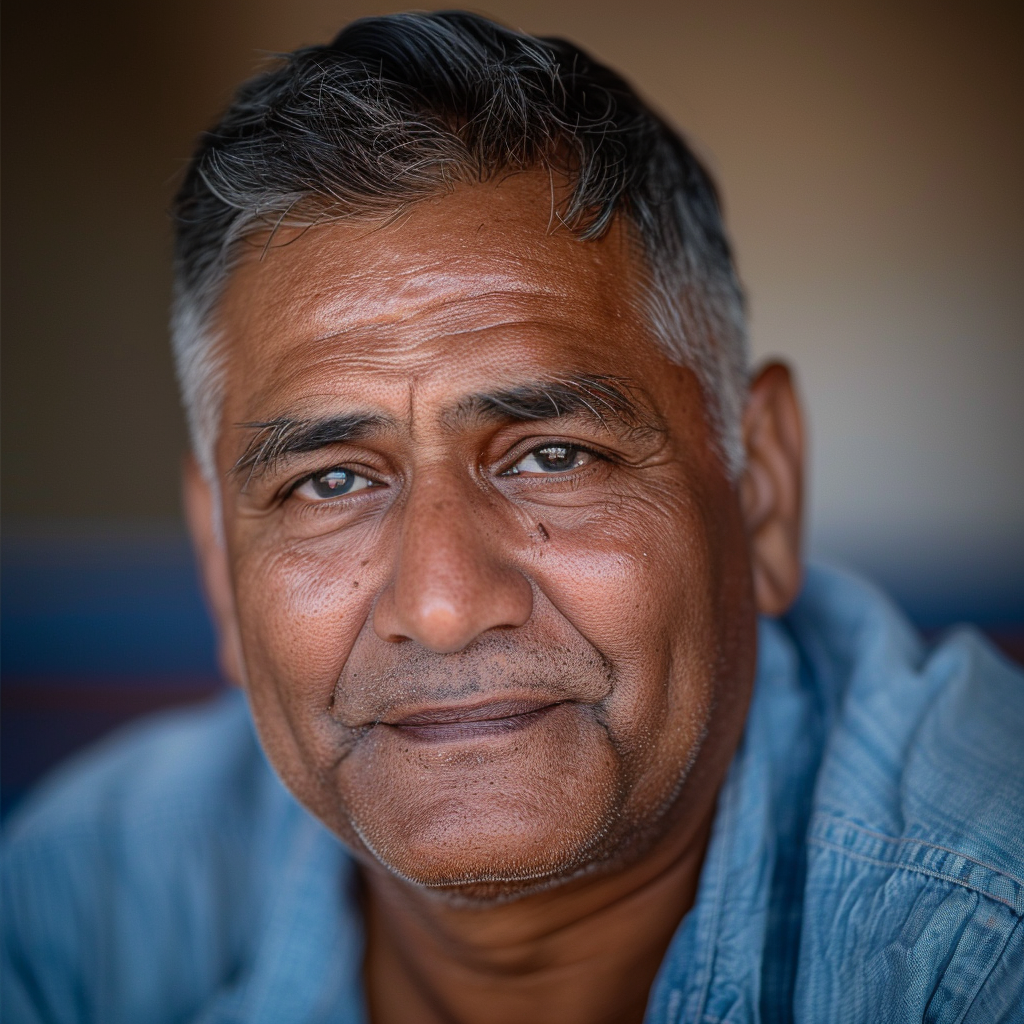

## Example 2

{
  "key": [
    "stance-detection-part-1",
    "gpt-4o",
    "mj_data_108_U2.png"
  ],
  "value": {
    "Positive High-Energy Emotions|Triumph": 4,
    "Positive High-Energy Emotions|Interest": 5,
    "Positive High-Energy Emotions|Awe": 3,
    "Positive High-Energy Emotions|Astonishment/Surprise": 4,
    "Positive Low-Energy Emotions|Contemplation": 5,
    "Positive Low-Energy Emotions|Pride": 4,
    "Negative High-Energy Emotions|Anger": 2,
    "Negative High-Energy Emotions|Fear": 1,
    "Positive Low-Energy Emotions|Contentment": 3,
    "Negative High-Energy Emotions|Malevolence/Malice": 1,
    "Negative High-Energy Emotions|Disgust": 2,
    "Negative High-Energy Emotions|Impatience and Irritability": 6,
    "Negative High-Energy Emotions|Distress": 2,
    "Negative Low-Energy Emotions|Sadness": 1,
    "Negative Low-Energy Emotions|Bitterness": 2,
    "Negative Low-Energy Emotions|Contempt": 2,
    "Negative Low-Energy Emotions|Disappointment": 6,
    "Negative Low-Energy Emotions|Shame": 1,
    "Negative Low-Energy Emotions|Emotional Numbness": 1,
    "Negative Low-Energy Emotions|Doubt": 6,
    "Negative Low-Energy Emotions|Jealousy & Envy": 2,
    "Cognitive States and Processes|Confusion": 7,
    "Cognitive States and Processes|Concentration": 5,
    "Physical and Exhaustive States|Fatigue/Exhaustion": 5,
    "Physical and Exhaustive States|Intoxication/Altered States of Consciousness": 3
  }
}

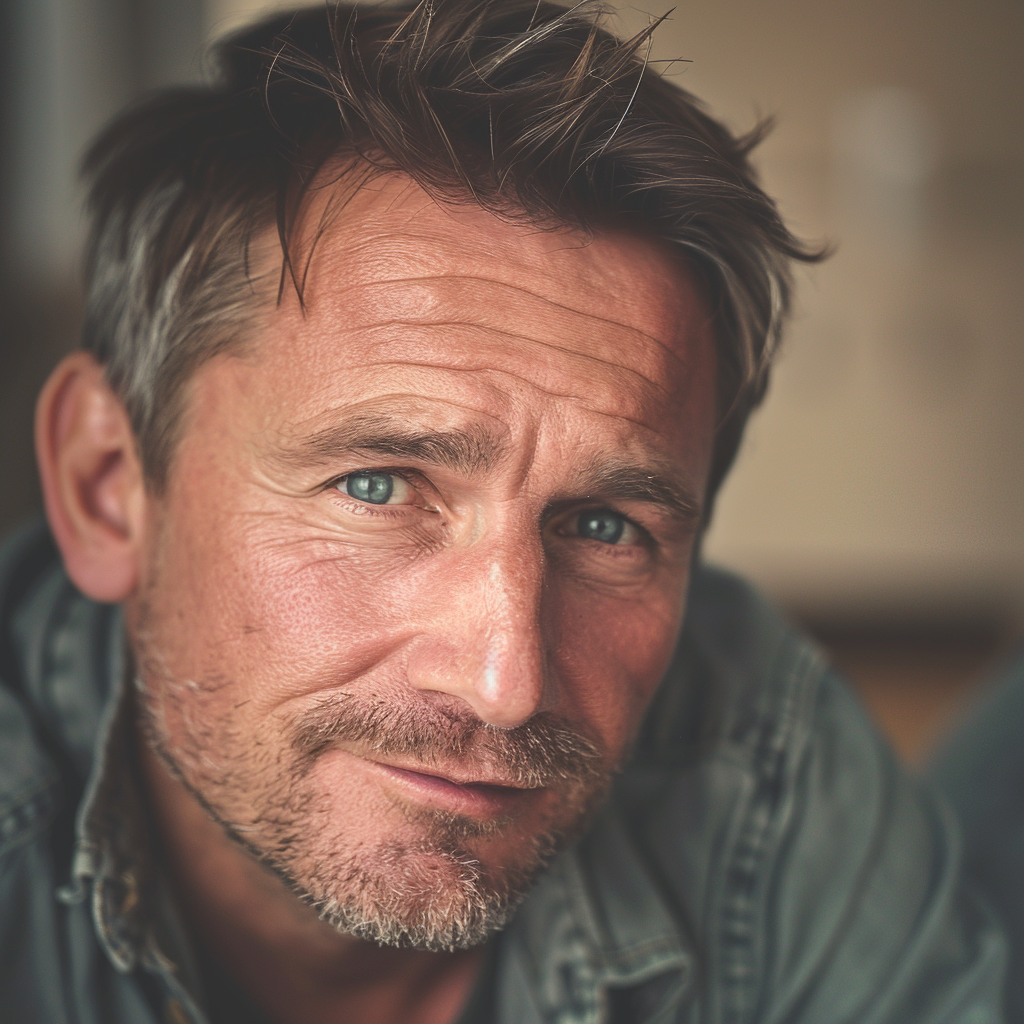